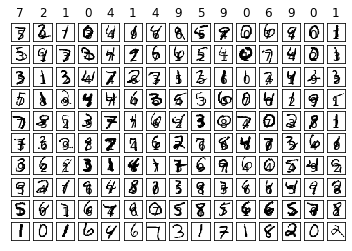

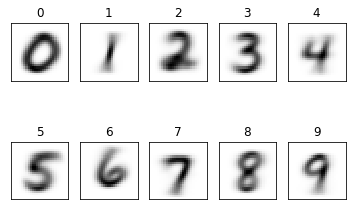

In [2]:
  import matplotlib.pyplot as plt
  import numpy as np

  file_data   = "mnist.csv"
  handle_file = open(file_data, "r")
  data        = handle_file.readlines()
  handle_file.close()

  size_row    = 28    # height of the image
  size_col    = 28    # width of the image

  num_image   = len(data)
  count       = 0     # count for the number of images

  #
  # normalize the values of the input data to be [0, 1]
  #
  def normalize(data):

      data_normalized = (data - min(data)) / (max(data) - min(data))

      return(data_normalized)

  #
  # example of distance function between two vectors x and y
  #
  def distance(x, y):

      d = (x - y) ** 2
      s = np.sum(d)
      # r = np.sqrt(s)

      return(s)

  #
  # make a matrix each column of which represents an images in a vector form
  #
  list_image  = np.empty((size_row * size_col, num_image), dtype=float)
  list_label  = np.empty(num_image, dtype=int)

  for line in data:

      line_data   = line.split(',')
      label       = line_data[0]
      im_vector   = np.asfarray(line_data[1:])
      im_vector   = normalize(im_vector)

      list_label[count]       = label
      list_image[:, count]    = im_vector

      count += 1

  #
  # plot first 150 images out of 10,000 with their labels
  #
  f1 = plt.figure(1)

  for i in range(150):

      label       = list_label[i]
      im_vector   = list_image[:, i]
      im_matrix   = im_vector.reshape((size_row, size_col))

      plt.subplot(10, 15, i+1)
      plt.title(label)
      plt.imshow(im_matrix, cmap='Greys', interpolation='None')

      frame   = plt.gca()
      frame.axes.get_xaxis().set_visible(False)
      frame.axes.get_yaxis().set_visible(False)


  #plt.show()

  #
  # plot the average image of all the images for each digit
  #
  f2 = plt.figure(2)

  im_average  = np.zeros((size_row * size_col, 10), dtype=float)
  im_count    = np.zeros(10, dtype=int)

  for i in range(num_image):

      im_average[:, list_label[i]] += list_image[:, i]
      im_count[list_label[i]] += 1

  for i in range(10):

      im_average[:, i] /= im_count[i]

      plt.subplot(2, 5, i+1)
      plt.title(i)
      plt.imshow(im_average[:,i].reshape((size_row, size_col)), cmap='Greys', interpolation='None')

      frame   = plt.gca()
      frame.axes.get_xaxis().set_visible(False)
      frame.axes.get_yaxis().set_visible(False)

  plt.show()

In [29]:
from collections import OrderedDict

class Affine:
  def __init__(self, W):
    self.W = W
    self.x = None
    self.dW = None

  def forward(self, x):
    x = np.concatenate((np.expand_dims(np.ones(x.shape[0]), axis = 1), x), axis = 1)
    self.x = x
    out = np.dot(x, self.W)
    return out
  
  def backward(self, dout):
    dx = np.dot(dout, self.W.T[:,1:])
    self.dW = np.dot(self.x.T, dout)
    return dx

class sigmoid:
  def __init__(self):
    self.out = None

  def forward(self,x):
      out = 1. / (1. + np.exp(-x))
      self.out = out
      return out

  def backward(self,dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx

class ThreeLayerNet:
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, rambda = 1, std = 0.1):
        
        self.rambda = rambda
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size+1, hidden_size1) # xavier
        self.params['W2'] = std * np.random.randn(hidden_size1+1, hidden_size2)
        self.params['W3'] = std * np.random.randn(hidden_size2+1, output_size)
        #np.concatenate((np.random.randn(input_size+1, hidden_size1).T, np.expand_dims(np.ones(hidden_size1), axis = 1)), axis = 1)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'])
        self.layers['sigmoid1'] = sigmoid()
        self.layers['Affine2'] = Affine(self.params['W2'])
        self.layers['sigmoid2'] = sigmoid()
        self.layers['Affine3'] = Affine(self.params['W3'])
        self.layers['sigmoid3'] = sigmoid()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t, rambda):
        y = self.predict(x)

        t = np.int64(np.expand_dims(t, axis = 1))
        a = np.zeros((t.shape[0],10), dtype = int)
        for i in range(t.shape[0]):
          a[i,t[i]] = 1
        delta = 1e-7
        return -np.sum(a * np.log(y + delta) + (1-a) * np.log(1-y+delta)) / float(x.shape[0]) + rambda / 2 / x.shape[0] \
    * (np.sum(np.power(self.params['W1'], 2))+np.sum(np.power(self.params['W2'],2))+np.sum(np.power(self.params['W3'],2)))
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x : 입력 데이터, t : 정답 레이블
        
    def gradient(self, x, t, rambda):
 
        y = self.predict(x)
        t = np.int64(np.expand_dims(t, axis = 1))
        a = np.zeros((t.shape[0],10), dtype = int)
        for i in range(t.shape[0]):
          a[i,t[i]] = 1
        dout = y-a

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['W2'] = self.layers['Affine2'].dW
        grads['W3'] = self.layers['Affine3'].dW

        return grads

In [30]:
x_train = list_image[:, :1000].T
t_train = list_label[:1000]
x_test = list_image[:, 1000:].T
t_test = list_label[1000:]

In [32]:
network = ThreeLayerNet(input_size=784, hidden_size1=196, hidden_size2 = 49, output_size=10, rambda = 1)
iters_num = 3000
train_size = x_train.shape[0]
learning_rate = 0.001
train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []
decay = 0.001

for i in range(iters_num):
    
    grad = network.gradient(x_train, t_train, network.rambda) 
    for key in ('W1','W2','W3'):
        network.params[key] -= learning_rate * grad[key] + learning_rate * network.rambda / x_train.shape[0] * network.params[key]
    
    train_loss = network.loss(x_train, t_train, network.rambda)  
    test_loss = network.loss(x_test, t_test, network.rambda)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    train_acc = network.accuracy(x_train, t_train)
    test_acc = network.accuracy(x_test, t_test)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    if i % 10 == 0:
        learning_rate = learning_rate * 1/(1 + decay)
        print(train_loss, test_loss, train_acc, test_acc)

4.290766813473803 3.565071248416873 0.106 0.11066666666666666
4.062810807730047 3.345003929092973 0.129 0.11377777777777778
4.055083071689868 3.33987347251643 0.129 0.11333333333333333
4.04868328582488 3.334575054326093 0.129 0.114
4.0421675975882865 3.3287156443167687 0.13 0.115
4.035400481302004 3.322499513795393 0.134 0.117
4.028280324606994 3.3159264858823727 0.135 0.11877777777777777
4.020695850364343 3.308921963826659 0.137 0.12222222222222222
4.012520685777417 3.3013810443000473 0.141 0.12411111111111112
4.003608483493863 3.2931769946931104 0.142 0.12733333333333333
3.9937866499294534 3.2841587701247095 0.145 0.131
3.982847963732074 3.274143854815167 0.151 0.13544444444444445
3.970539334958513 3.2629072523494607 0.159 0.14155555555555555
3.956547320859849 3.2501661655649015 0.169 0.15233333333333332
3.940481719409707 3.2355607826154227 0.185 0.16522222222222221
3.9218639063401053 3.2186362903687384 0.206 0.18244444444444444
3.9001401877647273 3.198844984058573 0.231 0.2134444444

1.6199736695536548 1.0420044974806466 0.953 0.8681111111111111
1.616514298869911 1.0394259292673569 0.953 0.8682222222222222
1.6131209330759675 1.0369104909975035 0.957 0.8685555555555555
1.6097918317496065 1.034456638691219 0.959 0.8684444444444445
1.606525316059393 1.0320628792105673 0.96 0.8688888888888889
1.60331976611381 1.0297277659920667 0.96 0.869
1.600173618384987 1.0274498949062698 0.96 0.8692222222222222
1.5970853632090904 1.0252279002964837 0.962 0.8694444444444445
1.594053542366607 1.023060451246764 0.963 0.8695555555555555
1.5910767467467155 1.0209462481247713 0.963 0.8695555555555555
1.5881536141005435 1.018884019438223 0.963 0.8698888888888889
1.585282826888343 1.0168725190349523 0.964 0.8702222222222222
1.5824631102254476 1.0149105236665326 0.965 0.8703333333333333
1.579693229931281 1.012996830924724 0.965 0.8704444444444445
1.5769719906847008 1.0111302575493109 0.965 0.8702222222222222
1.574298234287689 1.009309638095858 0.965 0.8702222222222222
1.5716708380378646 1.0

1.4282205137669177 0.9343933287521295 0.986 0.8791111111111111
1.4277643162452733 0.9342368487432348 0.986 0.8793333333333333
1.4273148147167583 0.934083169549328 0.986 0.8794444444444445
1.4268719033184316 0.933932248478338 0.986 0.8795555555555555
1.4264354778348705 0.9337840435876251 0.986 0.8795555555555555
1.4260054356839342 0.9336385137057243 0.987 0.8797777777777778
1.425581675902691 0.9334956184547007 0.987 0.8796666666666667
1.4251640991336971 0.9333553182725933 0.987 0.8795555555555555
1.4247526076117911 0.9332175744354445 0.987 0.8795555555555555
1.4243471051515217 0.9330823490784758 0.987 0.8795555555555555
1.423947497135293 0.9329496052159731 0.987 0.8796666666666667
1.4235536905022896 0.9328193067594939 0.987 0.8796666666666667
1.4231655937382006 0.9326914185340117 0.987 0.8795555555555555
1.422783116865742 0.932565906291634 0.986 0.8794444444444445
1.4224061714359357 0.9324427367225379 0.986 0.8794444444444445
1.422034670520092 0.9323218774627684 0.986 0.8793333333333333

# Plot the loss curve

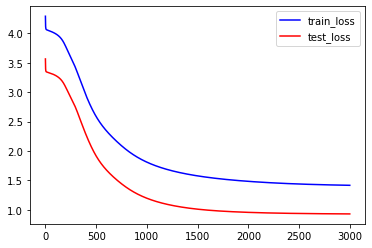

In [33]:
a = [i for i in range(3000)]
plt.plot(a, train_loss_list,label = 'train_loss', c = 'b')
plt.plot(a, test_loss_list,label = 'test_loss', c = 'r')
plt.legend()
plt.show()

# Plot the accuracy curve

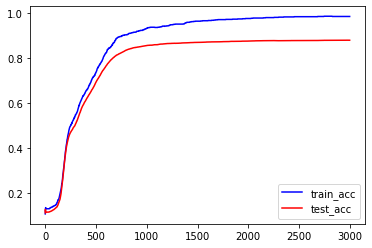

In [34]:
plt.plot(a, train_acc_list,label = 'train_acc', c = 'b')
plt.plot(a, test_acc_list,label = 'test_acc', c = 'r')
plt.legend()
plt.show()

# Plot the accuracy value

In [35]:
print("final train accuracy: {0}%".format(train_acc*100))

final train accuracy: 98.6%


In [36]:
print("final test accuracy: {0}%".format(test_acc*100))

final test accuracy: 88.0111111111111%


In [37]:
output = network.predict(x_test)
output = np.argmax(output, axis = 1)

In [38]:
correct_count = 0
incorrect_count = 0
image_idx = 0
correct_label = []
incorrect_label = []

while correct_count < 10 or incorrect_count < 10:
  if output[image_idx] == t_test[image_idx]:
    correct_count += 1
    correct_label.append(image_idx)
  else:
    incorrect_count += 1
    incorrect_label.append((image_idx, output[image_idx]))

  image_idx += 1


# 10 correctly classified testing images

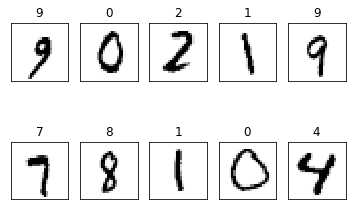

In [39]:
f1 = plt.figure(1)

for i in range(10):
      label       = t_test[correct_label[i]]
      im_vector   = x_test[correct_label[i],:]
      im_matrix   = im_vector.reshape((size_row, size_col))

      plt.subplot(2, 5, i+1)
      plt.title(label)
      plt.imshow(im_matrix, cmap='Greys', interpolation='None')

      frame   = plt.gca()
      frame.axes.get_xaxis().set_visible(False)
      frame.axes.get_yaxis().set_visible(False)
  

# 10 incorrectly classified testing images

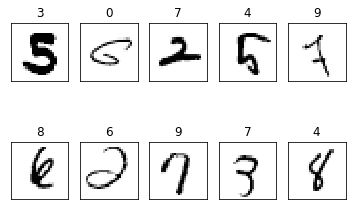

In [40]:
for i in range(10):
      label       = incorrect_label[i][1]
      im_vector   = x_test[incorrect_label[i][0],:]
      im_matrix   = im_vector.reshape((size_row, size_col))

      plt.subplot(2, 5, i+1)
      plt.title(label)
      plt.imshow(im_matrix, cmap='Greys', interpolation='None')

      frame   = plt.gca()
      frame.axes.get_xaxis().set_visible(False)
      frame.axes.get_yaxis().set_visible(False)